<h1>
	A Pruning-Based Deep Learning Approach for Information Retrieval
</h1>

Authors:


*   Luca Zanchetta (zanchetta.1848878@studenti.uniroma1.it)
*   Pasquale Mocerino (mocerino.1919964@studenti.uniroma1.it)
*   Simone Scaccia (scaccia.2045976@studenti.uniroma1.it)

This notebook introduces a refined approach to information retrieval by enhancing an existing inverted
index framework through pruning and fine-tuning techniques within the realm of deep learning.
Our work focuses on optimizing an established model, denoted as f, which takes a query q as input
and produces a ranked list of document IDs. By leveraging deep learning methodologies, we have
meticulously pruned and fine-tuned the existing framework to better capture semantic relationships
between queries and documents, thereby improving retrieval accuracy and efficiency.

Extensive experimentation on the proposed MS MARCO dataset validates the efficacy
of our refined approach, showcasing notable enhancements in retrieval performance compared to
the unmodified baseline. We have analyzed the effects of pruning and fine-tuning methods in order
to understand how they improve our model. This helps us see exactly how we can make the model
work better within the inverted index system.



## Dependencies and Import Statements

In [ ]:
%%capture
!pip install pyserini==0.12.0
!pip install transformers
!pip install pytorch_lightning

In [ ]:
import json
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune

from pyserini.search import get_topics
from pyserini.search import SimpleSearcher
from torch.utils.data import Dataset, DataLoader, random_split
from tokenizers import Tokenizer, trainers
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from sklearn.model_selection import train_test_split

In [ ]:
searcher = SimpleSearcher.from_prebuilt_index("msmarco-passage")
torch.cuda.empty_cache()

Attempting to initialize pre-built index msmarco-passage.


index-msmarco-passage-20201117-f87c94.tar.gz: 2.07GB [01:15, 29.3MB/s]                            


Extracting /root/.cache/pyserini/indexes/index-msmarco-passage-20201117-f87c94.tar.gz into /root/.cache/pyserini/indexes/index-msmarco-passage-20201117-f87c94.1efad4f1ae6a77e235042eff4be1612d...
Initializing msmarco-passage...


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


## Hyperparameters

In [ ]:
global IS_TRAIN
global IS_TEST
global IS_SECOND_FINE_TUNING
global IS_PRUNING

IS_TRAIN = True
IS_TEST = True
IS_SECOND_FINE_TUNING = True
IS_PRUNING = True

K = 5
BATCH_SIZE = 8
NUM_EPOCHS_FIRST = 10
NUM_EPOCHS_SECOND = 15
LEARNING_RATE = 0.001
EPSILON = 1e-9
MODEL_NAME = "google-t5/t5-small"
PRUNING_RATE = 0.4

## Dataset Preprocessing

The MS MARCO (Microsoft MAchine Reading Comprehension) is a collection of datasets focused on deep learning
in search. The first dataset was a question answering dataset featuring 100,000 real Bing questions and a human
generated answer. Since then, different datasets were released. We accessed the MS MARCO dataset through the
Pyserini toolkit, the Python interface to Anserini, designed to support reproducible IR research. Specifically, we chose
the 0.12.0 release, adapting the BM25 baseline for the MS MARCO passage ranking task to our needs. The queries
are already distributed in Pyserini. We initialized a searcher with a pre-built index, which Pyserini will automatically
download, in order to search for a specific query with associated ranked document IDs. So, we selected the most
relevant K document IDs for each query of the dataset, as well as the first 1000 document IDs by relevance for the
Recall@1000 metric computation, used only for this purpose and not for training. Since we used the Hugging Face T5
tokenizer, we tokenized our dataset accordingly by first extracting the maximum sequence lengths for encoder and
decoder and then by applying the T5 tokenizer with the proper padding to maximum length. Finally, the dataset was
splitted into 70% training set, 10 % validation set and 20% test set.

In [ ]:
def get_dataset(K):
    topics = get_topics("msmarco-passage-dev-subset")
    dataset = []
    dataset_dict_1000 = {}

    for id in topics:
        query = topics[id]["title"]
        hits = searcher.search(query, max(K, 1000))
        query_ids = [json.loads(hit.raw)["id"] for hit in hits]

        dataset.append({"query": query, "document_ids": query_ids[:K]})
        dataset_dict_1000[query] = query_ids[:1000]

    return dataset, dataset_dict_1000

In [ ]:
dataset, dataset_1000 = get_dataset(K)

In [ ]:
# Tokenize input queries and relevant document IDs
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# Determine encoder seq_len
enc_seq_lens = []
for data_point in dataset:
    enc_seq_lens.append(
        int(
            tokenizer(
                "retrieve documents for: " + data_point["query"], return_tensors="pt"
            ).input_ids.shape[1]
        )
    )
enc_seq_len = max(enc_seq_lens)

# Determine decoder seq_len
decoder_sequence_lengths = []
for data_point in dataset:
    document_ids = data_point["document_ids"]
    doc_ids = tokenizer(" ".join(document_ids), return_tensors="pt").input_ids
    decoder_sequence_lengths.append(int(doc_ids.shape[1]))
DEC_SEQ_LEN = max(decoder_sequence_lengths)

# Determine decoder seq_len_1000
decoder_sequence_lengths_1000 = []
for document_ids in dataset_1000.values():
    doc_ids = tokenizer(" ".join(document_ids), return_tensors="pt").input_ids
    decoder_sequence_lengths_1000.append(int(doc_ids.shape[1]))
DEC_SEQ_LEN_1000 = max(decoder_sequence_lengths_1000)

# Build tokenized dataset
tokenized_dataset = []
for data_point in dataset:
    input_text = "retrieve documents for: " + data_point["query"]
    document_ids = data_point["document_ids"]
    input_ids = tokenizer(
        input_text, return_tensors="pt", max_length=enc_seq_len, padding="max_length"
    ).input_ids
    doc_ids = tokenizer(
        " ".join(document_ids),
        return_tensors="pt",
        max_length=DEC_SEQ_LEN,
        padding="max_length",
    ).input_ids
    tokenized_dataset.append(
        {
            "query": data_point["query"],
            "input_ids": input_ids,
            "decoder_input_ids": doc_ids,
        }
    )

# Train - Validation - Test split
train_val_data, test_ds = train_test_split(
    tokenized_dataset, test_size=0.2, random_state=42
)
train_ds, val_ds = train_test_split(
    train_val_data, test_size=0.125, random_state=42
)  # 0.125 * 0.8 = 0.1

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (3656 > 512). Running this sequence through the model will result in indexing errors


## Metrics

We assessed our model using the following metrics:
*   MAP (Mean Average Precision), used in IR to evaluate the effectiveness of search systems. To implement it,
we started from Precision@K, a measure of relevancy calculated as the number of relevant retrieved document
IDs divided by the total number of retrieved document IDs, so K. Hence, we defined the Average Precision
(AP) as the average of precision values calculated at the points in the ranking where each relevant document is
retrieved. Finally, the MAP is consequently defined as the mean of the average precision scores from a set of
queries.
*   Recall@1000, indicating the proportion of relevant document IDs found in the top-1000 results.

In [ ]:
def prec_at(K, pred_docs, ground_truth_docs):
    # pred_docs: list of lists of strings
    # ground_truth_docs: list of strings
    precision_sum = 0
    for predicted, target in zip(pred_docs, ground_truth_docs):
        predicted_set = set(predicted[:K])
        target_set = set(target.split())
        precision = len(predicted_set.intersection(target_set)) / len(predicted[:K])
        precision_sum += precision
    precision_at_k = precision_sum / len(pred_docs)
    return precision_at_k


def prec_at_k(pred_docs, ground_truth_docs):
    # Precision at K:  number of relevant documents retrieved divided by the total number of documents retrieved
    return prec_at(K, pred_docs, ground_truth_docs)


def avg_prec(pred_docs, ground_truth_docs):
    # Average Precision (AP): average of the precision values calculated at the points in the ranking where each relevant document is retrieved
    avg_prec = []
    for predicted, target in zip(pred_docs, ground_truth_docs):
        target_set = set(target.split())
        precisions = []
        for i, item in enumerate(predicted):
            if item in target:
                precisions.append(prec_at(i + 1, [predicted], [target]))
        avg_prec.append(np.mean(precisions) if len(precisions) > 0 else 0)
    return np.mean(avg_prec) if len(avg_prec) > 0 else 0


def recall_at_k(K, pred_docs, ground_truth_docs):
    recall_batch_sum = 0
    for predicted, target in zip(pred_docs, ground_truth_docs):
        predicted_set = set(predicted[:K])
        target_set = set(target)
        recall = len(predicted_set.intersection(target_set)) / len(target)
        recall_batch_sum += recall
    recall_at_k_batch = recall_batch_sum / len(pred_docs)
    return recall_at_k_batch


def recall_at_1000(pred_docs, ground_truth_docs):
    # Recall@1000
    return recall_at_k(1000, pred_docs, ground_truth_docs)

## Baseline Fine-Tuning

We performed the fine-tuning of a
pre-trained T5 model, in order to adapt it to our task: given a query q, the model should output a ranked list of document
IDs.

The T5 model was included in a PyTorch Lightning module, useful to define our specific training, validation and testing
logic. We handled the aggregation logic of losses and metrics. T5 uses the regular cross-entropy loss, and we used
Adam optimizer for training our model (with betas fixed to 0.9 and 0.98). The training hyperparameters we have
considered are mainly the number K of retrieved document IDs for each query, the batch size, the number of epochs,
the learning rate, the epsilon associated to the optimizer and the chosen T5 model.

### Training

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self):
        super(T5FineTuner, self).__init__()
        # Define tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

        # Define model configuration
        self.model_config = T5Config.from_pretrained(MODEL_NAME)

        # Initialize the model for conditional generation
        self.model = T5ForConditionalGeneration.from_pretrained(
            MODEL_NAME, config=self.model_config
        )

        # Loss data
        self.train_epoch = 0
        self.val_epoch = 0
        self.test_epoch = 0
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

        # Metrics data
        self.val_avg_precs = []
        self.val_avg_recall = []
        self.test_avg_recall = []
        self.test_avg_precs = []

        # Metrics to be plotted
        self.avg_train_losses = []
        self.avg_val_losses = []
        self.avg_test_losses = []
        self.MAPs = []
        self.recall = []

        self.max_dec_seq = max(DEC_SEQ_LEN, DEC_SEQ_LEN_1000)

    # Pruning function
    def prune_model(self):
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name="weight", amount=PRUNING_RATE)

    def check_sparsity(self):
        total_params = 0
        total_zero_params = 0

        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Linear):
                total_params += module.weight.nelement()
                total_zero_params += torch.sum(module.weight == 0).item()

        sparsity = total_zero_params / total_params
        print(f"Model sparsity: {sparsity}")

    def training_step(self, batch, batch_idx):
        # (batch_size, 1, seq_len) --> (batch_size, seq_len)
        input_ids = batch["input_ids"].squeeze(1)
        decoder_input_ids = batch["decoder_input_ids"].squeeze(1)

        outputs = self.model(input_ids=input_ids, labels=decoder_input_ids)
        loss = outputs.loss
        self.train_losses.append(loss.item())

        self.log("train_loss", loss, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Average loss for the epoch
        avg_train_loss = round(sum(self.train_losses) / len(self.train_losses), 5)
        print(f"[Training] Epoch: {self.train_epoch}; Avg Loss: {avg_train_loss}\n")

        self.avg_train_losses.append(avg_train_loss)
        self.train_losses = []
        self.train_epoch += 1

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"].squeeze(1)
        decoder_input_ids = batch["decoder_input_ids"].squeeze(1)
        queries = batch["query"]

        outputs = self.model(input_ids=input_ids, labels=decoder_input_ids)
        loss = outputs.loss
        self.val_losses.append(loss.item())

        # Inference
        model_output = self.model.generate(input_ids, max_length=self.max_dec_seq)

        predicted_ids = []
        predicted_ids_1000 = []
        for sublist in model_output:
            decoded = self.tokenizer.decode(
                sublist[:DEC_SEQ_LEN], skip_special_tokens=True
            )
            predicted_ids.append(decoded.split())
            decoded_1000 = self.tokenizer.decode(
                sublist[:DEC_SEQ_LEN_1000], skip_special_tokens=True
            )
            predicted_ids_1000.append(decoded_1000.split())

        target_ids = []
        for sublist in decoder_input_ids:
            decoded = self.tokenizer.decode(sublist, skip_special_tokens=True)
            target_ids.append(decoded)

        # Compute metrics
        self.val_avg_precs.append(avg_prec(predicted_ids, target_ids))
        self.val_avg_recall.append(
            recall_at_1000(
                predicted_ids_1000, [dataset_1000[query] for query in queries]
            )
        )

        self.log("val_loss", loss, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        # Average validation loss for the epoch
        avg_val_loss = round(sum(self.val_losses) / len(self.val_losses), 5)
        mean_avg_precision = round(
            (sum(self.val_avg_precs) / len(self.val_avg_precs)), 5
        )
        recall_at_1000 = round((sum(self.val_avg_recall) / len(self.val_avg_recall)), 5)

        print(
            f"[Validation] Epoch: {self.val_epoch}; Avg Loss: {avg_val_loss}\nMean Average Precision: {mean_avg_precision}; Recall@1000: {recall_at_1000}\n"
        )
        self.log("map", mean_avg_precision)
        self.log("recall@1000", recall_at_1000)

        self.val_losses = []
        self.val_avg_precs = []
        self.val_avg_recall = []

        self.avg_val_losses.append(avg_val_loss)
        self.MAPs.append(mean_avg_precision)
        self.recall.append(recall_at_1000)

        self.val_epoch += 1

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"].squeeze(1)
        decoder_input_ids = batch["decoder_input_ids"].squeeze(1)
        queries = batch["query"]

        outputs = self.model(input_ids=input_ids, labels=decoder_input_ids)
        loss = outputs.loss
        if loss is not None:
            self.test_losses.append(loss.item())

        model_output = self.model.generate(input_ids, max_length=self.max_dec_seq)

        predicted_ids = []
        predicted_ids_1000 = []
        for sublist in model_output:
            decoded = self.tokenizer.decode(
                sublist[:DEC_SEQ_LEN], skip_special_tokens=True
            )
            predicted_ids.append(decoded.split())
            decoded_1000 = self.tokenizer.decode(
                sublist[:DEC_SEQ_LEN_1000], skip_special_tokens=True
            )
            predicted_ids_1000.append(decoded_1000.split())

        target_ids = []
        for sublist in decoder_input_ids:
            decoded = self.tokenizer.decode(sublist, skip_special_tokens=True)
            target_ids.append(decoded)

        # Compute metrics
        self.test_avg_precs.append(avg_prec(predicted_ids, target_ids))
        self.test_avg_recall.append(
            recall_at_1000(
                predicted_ids_1000, [dataset_1000[query] for query in queries]
            )
        )

        # Print target and predicted document IDs for the first batch
        if batch_idx == 0:
            for target, predicted in zip(target_ids, predicted_ids):
                print(f"Target document IDs: {target}")
                print(f"Predicted document IDs: {' '.join(predicted)}\n")

        self.log("test_loss", loss, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        # Average test loss for the epoch
        avg_test_loss = round(sum(self.test_losses) / len(self.test_losses), 5)
        mean_avg_precision = round(
            (sum(self.test_avg_precs) / len(self.test_avg_precs)), 5
        )
        recall_at_1000 = round(
            (sum(self.test_avg_recall) / len(self.test_avg_recall)), 5
        )

        print(
            f"[Testing] Epoch: {self.test_epoch}; Avg Loss: {avg_test_loss}\nMean Average Precision: {mean_avg_precision}; Recall@1000: {recall_at_1000}"
        )

        self.test_losses = []
        self.test_avg_precs = []
        self.test_avg_recall = []

        self.avg_test_losses.append(avg_test_loss)

        self.test_epoch += 1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=LEARNING_RATE, eps=EPSILON, betas=(0.9, 0.98)
        )
        return optimizer

In [ ]:
if IS_TRAIN:
    lightning_model = T5FineTuner()

    trainer = pl.Trainer(
        max_epochs=NUM_EPOCHS_FIRST,
        accelerator="auto",
    )
    trainer.fit(lightning_model, train_dataloader, val_dataloader)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 0; Avg Loss: 6.44356
Mean Average Precision: 0.0; Recall@1000: 0.0



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 1; Avg Loss: 3.4415
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 0; Avg Loss: 3.53859



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 2; Avg Loss: 3.35007
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 1; Avg Loss: 3.31533



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 3; Avg Loss: 3.33888
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 2; Avg Loss: 3.23281



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 4; Avg Loss: 3.36542
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 3; Avg Loss: 3.14524



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 5; Avg Loss: 3.4102
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 4; Avg Loss: 3.02694



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 6; Avg Loss: 3.49166
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 5; Avg Loss: 2.84686



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 7; Avg Loss: 3.71351
Mean Average Precision: 0.00085; Recall@1000: 1e-05

[Training] Epoch: 6; Avg Loss: 2.58122



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 8; Avg Loss: 4.05124
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 7; Avg Loss: 2.232



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 9; Avg Loss: 4.5024
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 8; Avg Loss: 1.82327



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 10; Avg Loss: 5.17492
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 9; Avg Loss: 1.41426



INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Inference

In [ ]:
if IS_TEST:
    tester = pl.Trainer(max_epochs=1, accelerator="auto")
    tester.test(lightning_model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Target document IDs: 7238811 7238810 7238816 3953645 5896839
Predicted document IDs: 7538596 7285301 7538597 7285301 7538599

Target document IDs: 8028212 1414539 1414533 5431886 8273554
Predicted document IDs: 53505 5350571 5350568 1385681 3568034

Target document IDs: 4212183 4212182 868794 5064714 7869251
Predicted document IDs: 734893 3491461 3491457 3491458 3491458

Target document IDs: 8562786 8562783 8562782 2515656 3881094
Predicted document IDs: 7817750 7593548 7593544 7593539 7593539

Target document IDs: 7545520 8490122 8490127 7545519 7545517
Predicted document IDs: 7218173 7521112 1125776 1372200 7218171

Target document IDs: 1052724 1658555 7676446 1052723 1052725
Predicted document IDs: 7693210 7217516 7693201 7693199 7693201

Target document IDs: 2741756 2741763 7811902 7254873 7811905
Predicted document IDs: 7896067 1981ziomaggio 2957617 4242072

Target document IDs: 2126444 7926200 6240814 6042503 334015
Predicted document IDs: 7100724 1008035 7100722 5067874 7100721


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.093562602996826     │
└───────────────────────────┴───────────────────────────┘

## First Model Plots

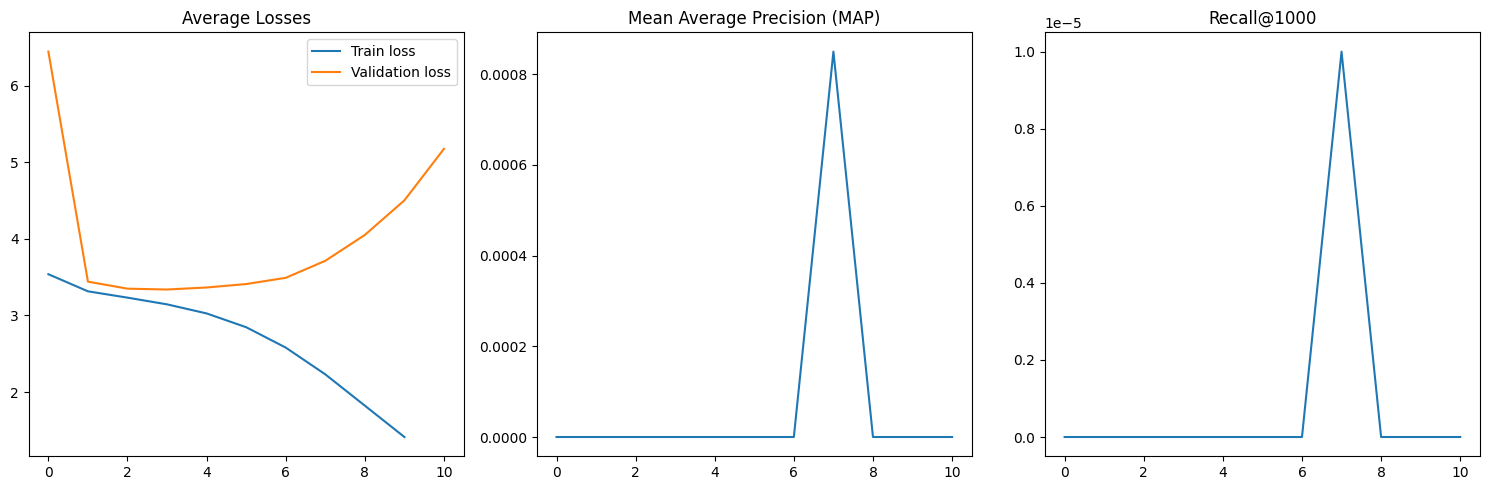

In [ ]:
# Data to be plotted
train_loss = lightning_model.avg_train_losses
val_loss = lightning_model.avg_val_losses
MAPs = lightning_model.MAPs
recall = lightning_model.recall

# Create figure and subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].plot(train_loss, label="Train loss")
axs[0].plot(val_loss, label="Validation loss")
axs[0].set_title("Average Losses")
axs[0].legend()

# Second subplot
axs[1].plot(MAPs)
axs[1].set_title("Mean Average Precision (MAP)")

# Third subplot
axs[2].plot(recall)
axs[2].set_title("Recall@1000")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Pruning

Our baseline is the
result of a first fine-tuning of the whole model. Our proposed innovation is to provide a model compression technique on
this baseline in order to use this model in a resource constrained environment, showing promising future improvements.

In [ ]:
# Model sparsity before pruning
lightning_model.check_sparsity()

Model sparsity: 0.0


In [ ]:
lightning_model.prune_model()

In [ ]:
# Model sparsity after pruning
lightning_model.check_sparsity()

Model sparsity: 0.4000003107965703


## Second Fine-Tuning

After pruning, the model's performance may degrade due to the removal of certain parameters or connections. Recovery techniques aim to mitigate this performance loss by retraining the pruned model and fine-tuning its remaining parameter.

### Training

In [ ]:
if IS_SECOND_FINE_TUNING:
    trainer = pl.Trainer(
        max_epochs=NUM_EPOCHS_SECOND,
        accelerator="auto",
    )
    trainer.fit(lightning_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 11; Avg Loss: 6.05682
Mean Average Precision: 0.0; Recall@1000: 0.0



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 12; Avg Loss: 5.20087
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 10; Avg Loss: 1.73404



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 13; Avg Loss: 6.11584
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 11; Avg Loss: 0.98075



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 14; Avg Loss: 7.04257
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 12; Avg Loss: 0.6079



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 15; Avg Loss: 7.79826
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 13; Avg Loss: 0.40085



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 16; Avg Loss: 8.4824
Mean Average Precision: 0.00142; Recall@1000: 0.0

[Training] Epoch: 14; Avg Loss: 0.28491



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 17; Avg Loss: 8.95651
Mean Average Precision: 0.0; Recall@1000: 1e-05

[Training] Epoch: 15; Avg Loss: 0.22271



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 18; Avg Loss: 9.31255
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 16; Avg Loss: 0.19076



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 19; Avg Loss: 9.6249
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 17; Avg Loss: 0.16681



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 20; Avg Loss: 9.81725
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 18; Avg Loss: 0.15516



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 21; Avg Loss: 9.96787
Mean Average Precision: 0.0; Recall@1000: 1e-05

[Training] Epoch: 19; Avg Loss: 0.14013



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 22; Avg Loss: 10.13186
Mean Average Precision: 0.0; Recall@1000: 1e-05

[Training] Epoch: 20; Avg Loss: 0.13194



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 23; Avg Loss: 10.34667
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 21; Avg Loss: 0.12783



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 24; Avg Loss: 10.35543
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 22; Avg Loss: 0.11615



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 25; Avg Loss: 10.56166
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 23; Avg Loss: 0.11025



Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 26; Avg Loss: 10.65761
Mean Average Precision: 0.0; Recall@1000: 0.0

[Training] Epoch: 24; Avg Loss: 0.1065



INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
# Model sparsity after training
lightning_model.check_sparsity()

Model sparsity: 0.4000003107965703


### Inference

In [ ]:
if IS_SECOND_FINE_TUNING:
    tester = pl.Trainer(max_epochs=1, accelerator="auto")
    tester.test(lightning_model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Target document IDs: 7238811 7238810 7238816 3953645 5896839
Predicted document IDs: 7569995 7569997 1811902 3396984 6306820

Target document IDs: 8028212 1414539 1414533 5431886 8273554
Predicted document IDs: 5451447 4204914 5451444 5451444 5451445

Target document IDs: 4212183 4212182 868794 5064714 7869251
Predicted document IDs: 73310 73310 73310 7331012 7331018

Target document IDs: 8562786 8562783 8562782 2515656 3881094
Predicted document IDs: 3670901 3670901 3636214 7730192 3670147

Target document IDs: 7545520 8490122 8490127 7545519 7545517
Predicted document IDs: 8077490 7627795 3377765 3310360 331030

Target document IDs: 1052724 1658555 7676446 1052723 1052725
Predicted document IDs: 4984048 2960827 4984048 2960831 7468264

Target document IDs: 2741756 2741763 7811902 7254873 7811905
Predicted document IDs: 4204772 5198894 4579974 7781363 7781369

Target document IDs: 2126444 7926200 6240814 6042503 334015
Predicted document IDs: 377th51 377th59 377th51 377th51 377th56

[

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     10.46073055267334     │
└───────────────────────────┴───────────────────────────┘

## Pruned Model Plots

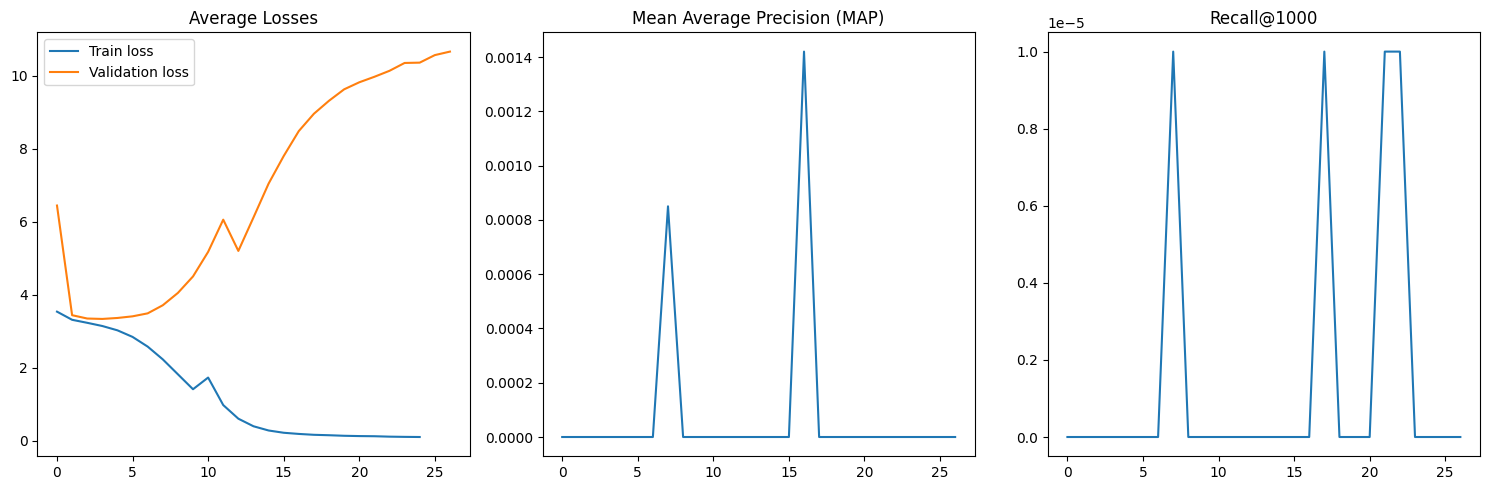

In [ ]:
# Data to be plotted
train_loss = lightning_model.avg_train_losses
val_loss = lightning_model.avg_val_losses
MAPs = lightning_model.MAPs
recall = lightning_model.recall

# Create figure and subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].plot(train_loss, label="Train loss")
axs[0].plot(val_loss, label="Validation loss")
axs[0].set_title("Average Losses")
axs[0].legend()

# Second subplot
axs[1].plot(MAPs)
axs[1].set_title("Mean Average Precision (MAP)")

# Third subplot
axs[2].plot(recall)
axs[2].set_title("Recall@1000")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Results
We have executed a train-prune-recovery approach: we have trained the baseline for 10 epochs, then we have pruned the model with different pruning rates, and finally we have fine-tuned the model on the same dataset for other 15 epochs.

We performed hyperparameter tuning on the t5-small model. Our aim was to
understand the hyperparameters leading to the best performance in terms of the Mean Average Precision (MAP) and Recall@1000 metrics.

The most notable results we have obtained are summarized in the following tables:

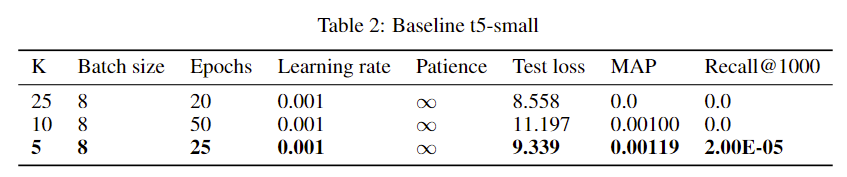

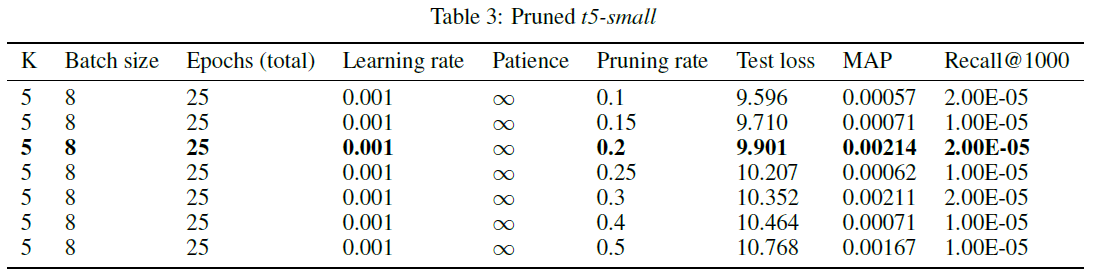

As we can see from tables 2 and 3, the train-prune-recovery cycle
we propose in this paper is actually improving the performance of the model with respect to the baseline, proving that
our approach can be valid also in a less constrained environment.